## Convolutional Neural Network
   #### Computer Vision Winter Semester 2021/2022 by Clemens Spielvogel
    
Convolutional Neural Networks (CNNs) are variations of neural networks specifically made for computer vision tasks. Their main advantage over classical neural networks is the sparsity of connections and the sharing of parameters over different regions via the usage of convolutional filters.
The following code will demonstrate how to use Keras with Tensorflow backend for creating classification models for image data.

Installations (Ubuntu)
   * $ pip install plotly
   
Resources:
   * Tensorflow tutorials: https://www.tensorflow.org/tutorials/
   * Tensorflow guide: https://www.tensorflow.org/guide/
   * Tensorflow documentation: https://www.tensorflow.org/versions/r1.14/api_docs/python/tf
   * Keras documentation: https://keras.io/

In [1]:
import math
import random
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "" # If you want to use TF CPU version while having the GPU version installed

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import Sequential, layers, regularizers
import tensorflow.keras
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as ply
import plotly.graph_objs as graphs

print("Keras version", tf.keras.__version__)
print("TF version", tf.__version__)

Keras version 2.4.0
TF version 2.3.0


In [2]:
# Seeding random number generators to obtain reproducible results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value) # Resets itself on every use!
tf.random.set_seed(seed_value) # tf.set_random_seed(seed_value) on older TF versions

In [3]:
# Specify data location
data_dir = r"Data\mnist.csv"

# Set hyperparameters
num_epochs = 20
batch_size = 64
dims = (28, 28, 1)

In [4]:
def load_data(file_path):
    # Load CSV file to pandas data frame
    df = pd.read_csv(file_path, header=0)

    # Split data frame columns into features and labels
    y = df["label"].values
    X_flat = df.drop("label", axis=1).values
    X = [np.resize(array, (28, 28)) for array in X_flat] # Resize flat vector to 28x28
    X = np.array([np.reshape(sample, (sample.shape[0], sample.shape[1], 1)) for sample in X]) # Add color channel
    
    return X, tf.keras.utils.to_categorical(y) # Labels are returned as one-hot encoded vectors

In [5]:
# Load data
X, y = load_data(data_dir)

# Determine split sizes (Could also be hardcoded)
train_size = math.floor(0.8 * len(y))
val_size = math.floor(0.1 * len(y))
test_size = math.floor(0.1 * len(y))

# Create splitted sets
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

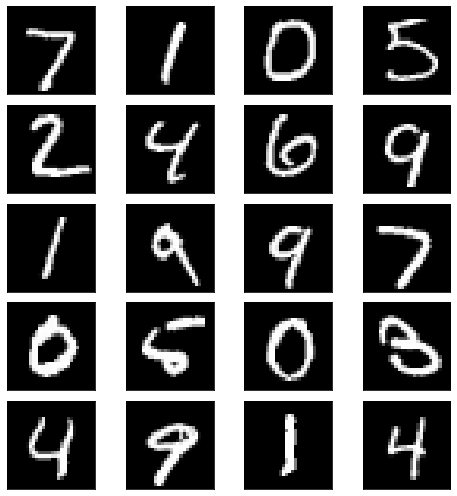

In [6]:
# Display example images
num_samples = 5 # Displayed samples per column
num_columns = 4
shift = 0 # To plot other samples

fig, ax = plt.subplots(num_samples, num_columns, figsize=(7, 7))
params = {"top": False, "bottom": False, "left": False, "right": False, "labelleft": False,
          "labelbottom": False}

for i in range(0, num_samples):
    for col_index in range(num_columns):    
        ax[i, col_index].imshow(X_train[i+num_samples*col_index+shift], cmap="gray")
        ax[i, col_index].tick_params(**params)

plt.tight_layout()
plt.show()

In [7]:
def create_2DCNN_model(input_shape):
    """Build architecture of the model"""
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), input_shape=input_shape,
                            activation="relu", padding="same"))
    model.add(layers.Conv2D(64, (3, 3), activation="selu", padding="same"))
    model.add(layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation="selu", padding="same"))
    model.add(layers.Conv2D(64, (3, 3), activation="selu", padding="same"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="selu", padding="same"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="selu",
                           kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="selu"))
    model.add(layers.Dense(10, activation="softmax"))

    # Create model
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [8]:
# Create CNN model
model = create_2DCNN_model(dims)

In [9]:
# Two possibilities to display specifications of your model
print(model.summary())
plot_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         7

In [10]:
# Configure stopping criterion via early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4, mode="min")

In [11]:
# Train model
train_summary = model.fit(x=X_train,
                          y=y_train,
                          validation_data=(X_val, y_val),
                          batch_size=batch_size,
                          epochs=num_epochs,
                          callbacks=[callback],
                          verbose=1)

Epoch 1/20
125/125 [==============================] - 1s 8ms/step - loss: 1.1404 - accuracy: 0.7431 - val_loss: 0.2121 - val_accuracy: 0.9670
Epoch 2/20
125/125 [==============================] - 1s 7ms/step - loss: 0.2849 - accuracy: 0.9456 - val_loss: 0.2247 - val_accuracy: 0.9590
Epoch 3/20
125/125 [==============================] - 1s 7ms/step - loss: 0.2114 - accuracy: 0.9653 - val_loss: 0.1298 - val_accuracy: 0.9930
Epoch 4/20
125/125 [==============================] - 1s 6ms/step - loss: 0.1710 - accuracy: 0.9769 - val_loss: 0.1297 - val_accuracy: 0.9900
Epoch 5/20
125/125 [==============================] - 1s 6ms/step - loss: 0.1528 - accuracy: 0.9809 - val_loss: 0.1386 - val_accuracy: 0.9840
Epoch 6/20
125/125 [==============================] - 1s 6ms/step - loss: 0.1521 - accuracy: 0.9808 - val_loss: 0.1184 - val_accuracy: 0.9900
Epoch 7/20
125/125 [==============================] - 1s 6ms/step - loss: 0.1334 - accuracy: 0.9866 - val_loss: 0.1133 - val_accuracy: 0.9910
Epoch 

In [12]:
# Evaluate fitted model using test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("\nTest ACC:", round(test_acc, 3))

32/32 [==============================] - 0s 3ms/step - loss: 0.1634 - accuracy: 0.9750

Test ACC: 0.975


In [13]:
def plot_train_val_performances(performances, metric="Accuracy", show=True):
    """Plot training vs. validation accuracy over all epochs. performances is a dictionary mapping epoch numbers
       as integers to lists containing training and validation performance (e.g. accuracy).
       metric is a string indicating the used performance metric."""
    x = list(performances.keys())     # Number of epoch
    y_train = [i[0] for i in performances.values()]
    y_val = [i[1] for i in performances.values()]

    trace_train = graphs.Scatter(x=x, y=y_train, name="Training", mode="lines+markers",
                                 line=dict(width=4),
                                 marker=dict(symbol="circle",
                                             size=10))
    trace_val = graphs.Scatter(x=x, y=y_val, name="Validation", mode="lines+markers",
                                line=dict(width=4),
                                marker=dict(symbol="circle",
                                            size=10))

    layout = graphs.Layout(title="Training vs. Validation {}".format(metric),
                           xaxis={"title": "Epoch"},
                           yaxis={"title": metric})

    fig = graphs.Figure(data=[trace_train, trace_val], layout=layout)
    ply.plot(fig, filename="plotly_train_val_{}.html".format(metric), auto_open=show)
    print("Plot saved as plotly_train_val_{}.html".format(metric))

In [14]:
# Get epochwise performances
train_acc = train_summary.history["accuracy"]
val_acc = train_summary.history["val_accuracy"]

# Format and store performances per epoch for plotting
accs = {epoch: [round(performance[0], 2), round(performance[1], 2)]
        for epoch, performance in enumerate(zip(train_acc, val_acc))}

# Plot training and validation performance over epochs
plot_train_val_performances(accs, "Accuracy")

Plot saved as plotly_train_val_Accuracy.html


In [15]:
# Save model
model.save_weights("model_weights.h5")

True class: 7
Predicted class: 2


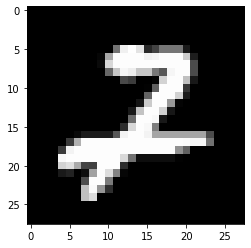

True class: 7
Predicted class: 2


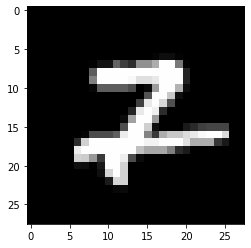

True class: 0
Predicted class: 2


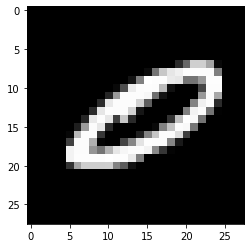

True class: 7
Predicted class: 2


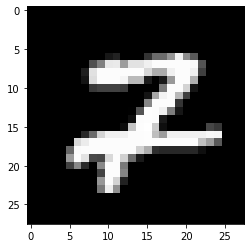

True class: 7
Predicted class: 2


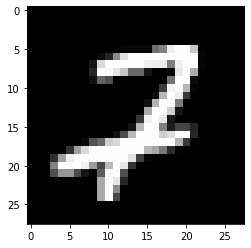

True class: 7
Predicted class: 2


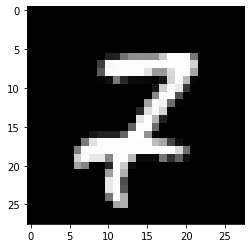

True class: 3
Predicted class: 2


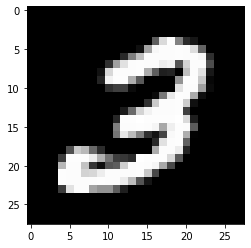

True class: 3
Predicted class: 2


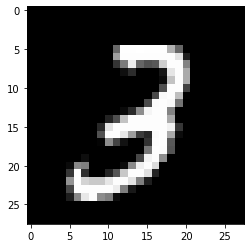

True class: 9
Predicted class: 4


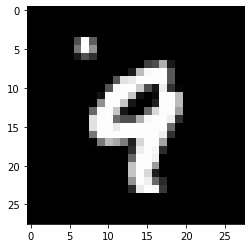

True class: 9
Predicted class: 7


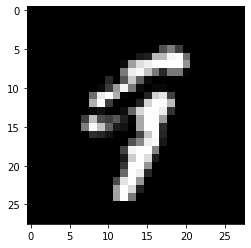

In [16]:
# Assessment of incorrectly identified instances

num_show = 10 # Maximum number of displayed instances

# Iterate through test instances
for X_instance, y_instance in zip(X_test, y_test):
    
    # Predict class for each instance
    y_pred_one_hot = model.predict(np.array([X_instance]))
    
    # Retrieve integer from one-hot encoded class
    y_pred = np.argmax(y_pred_one_hot)
    
    y_instance = np.argmax(y_instance)
    
    # Check whether class is incorrect
    if y_pred != y_instance and num_show > 0:
        # Display true and predicted class
        print("True class:", y_instance)
        print("Predicted class:", y_pred)
        
        # Display incorrectly predicted image
        plt.imshow(X_instance, cmap="gray")
        plt.show()
        
        # Update maximum number of images to show
        num_show -=1

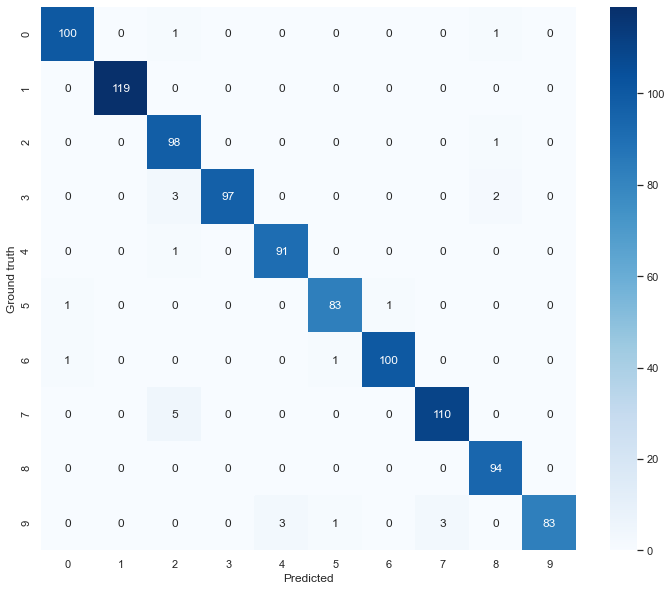

In [17]:
# Distribution of incorrectly classified instances

# Predict all test instances
y_pred = model.predict(X_test)

# Convert to integer labels
y_test_int = [np.argmax(val) for val in y_test]
y_pred_int = [np.argmax(val) for val in y_pred]
cm = confusion_matrix(y_test_int, y_pred_int)

sns.set(rc={'figure.figsize':(12, 10)})
 
fig = sns.heatmap(data=cm,
            cmap="Blues",
            annot=True,
            fmt="g")

fig.set(xlabel="Predicted", ylabel="Ground truth")

plt.show()